# 画图

In [67]:
%matplotlib notebook
import imp, time
from collections import Counter, OrderedDict, defaultdict, deque, namedtuple

import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from sklearn.cluster import KMeans
from scipy import constants as const
from scipy.fftpack import fft, hilbert, ifft
from scipy.optimize import curve_fit
from scipy.optimize import least_squares as ls
from sympy import diff, symbols
import pandas as pd
import qulab.optimize
from qulab.storage import connect
from qulab.storage.schema import Record, base
from qulab.storage.utils import save

op = imp.reload(qulab.optimize)
connect.connect()

In [2]:
def read(title=None,which=0):
    
    if title is None:
        x = Record.objects.order_by('-finished_time')[which]
    else:
        x = Record.objects(title=title).order_by('-finished_time')[which]
    tags, comment, name = x['tags'], x['comment'], x['title']
    data, ID = base.from_pickle(x.datafield), x.id
    return data, ID, comment, tags, name

In [3]:
def write(phase=None,addr='mongodb',height=2,title=None,which=0,peak=110):
    if addr == 'mongodb':
        data, ID, comment, tags, name = read(title=title,which=which)
    else:
        d = np.load(addr)
        data, tags = (d['row'],d['col'],d['s']), d['tags']

    if len(data) == 2:
        num = len(data[0].T)
        if phase == 'phase': 
            fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,height*num))
            fig.subplots_adjust(top=0.98,bottom=0.02,hspace=0.2)
            v = []
            for i in range(num): 
                f, s = data[0][:,i],data[1][:,i]
                v.append((f,s))
                if num != 1:
                    
                    axes[i][0].plot(f,abs(s))
                    axes[i][1].plot(f,np.angle(s))
                else:
                    axes[0].plot(f,abs(s))
                    axes[1].plot(f,np.angle(s))
        else:
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=n,figsize=(9,height*n))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                f, s = data[0][:,i],data[1][:,i]
                v.append((f,s))
                if n != 1:
                    axes[i//2][i%2].plot(f,abs(s))
                    #axes[i//2][i%2].set_title(name)
                else:
                    axes[i].plot(f,abs(s))
                    if addr == 'mongodb':
                        axes[i].set_title(name)
        return v,num,tags
    if len(data) == 3 :
        
        num = len(data[0].T)
        if phase == 'phase': 
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=num,figsize=(9,height*num))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                cols, rows, s= data[0][:,i], data[1][0,:], data[2][:,:,i]
                v.append((cols,rows,s))
                extent = [min(rows),max(rows),min(cols),max(cols)]
                if n != 1:
                    axes[i//2][i%2].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    #axes[i][1].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                else:
                    #axes[0].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    axes[i].imshow(np.angle(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
        else:
            n = num // 2 + num % 2
            fig, axes = plt.subplots(ncols=2,nrows=n,figsize=(9,height*n))
            fig.subplots_adjust(top=0.9,bottom=0.1,hspace=0.5)
            v = []
            for i in range(num): 
                cols, rows, s= data[0][:,i], data[1][0][:,i], data[2][:,:,i]

                s[np.abs(s) > peak] = s[np.abs(s)==np.min(np.abs(s))]
                v.append((cols,rows,s))
                extent = [min(rows),max(rows),min(cols),max(cols)]
                if n != 1:
                    axes[i//2][i%2].imshow(abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest')
                    axes[i//2][i%2].set_title(tags[0])
                else:
                    axes[i].imshow(np.abs(s),extent=extent,aspect='auto',origin='lower',interpolation='nearest',animated=True)
                    axes[i].set_title(tags[0])
        return v,num,tags

In [63]:
x = np.array([0,1,2])
x[:] = 1

In [73]:
np.array([2,4])/np.array([2,2])

array([1., 2.])

# qubit工作点

In [4]:

atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))


## 保存qubit工作点

In [221]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0327\QubitState\qubitstate_20200327084652.npz


In [220]:
q10 = q10._replace(inst={'dc': 'dc10', 'z_awg': 'awg131', 'z_ch': 8, 'ex_awg': 'awg132', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex3', 'com': 'com6'})

## 提取qubit工作点

In [489]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0331\QubitState\qubitstate_20200331220551.npz


# 查看图形

<IPython.core.display.Javascript object>


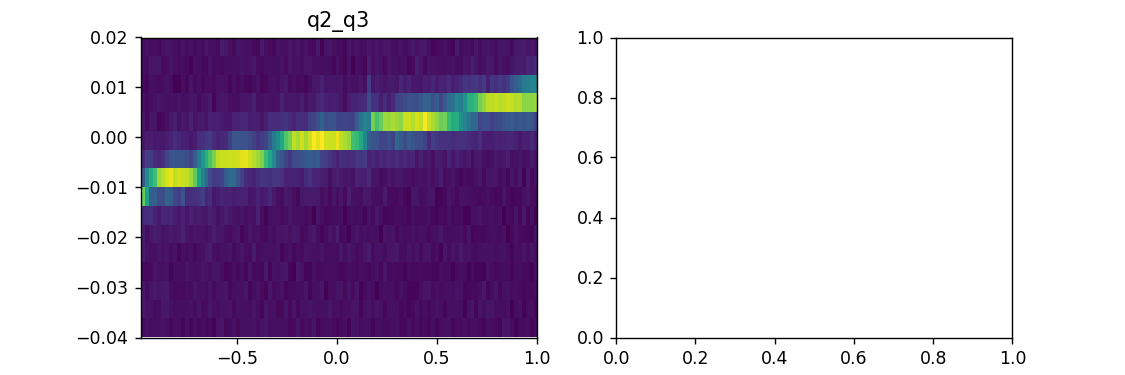

In [501]:
value,num,tags = write(height=3,which=0,peak=1120)

<IPython.core.display.Javascript object>


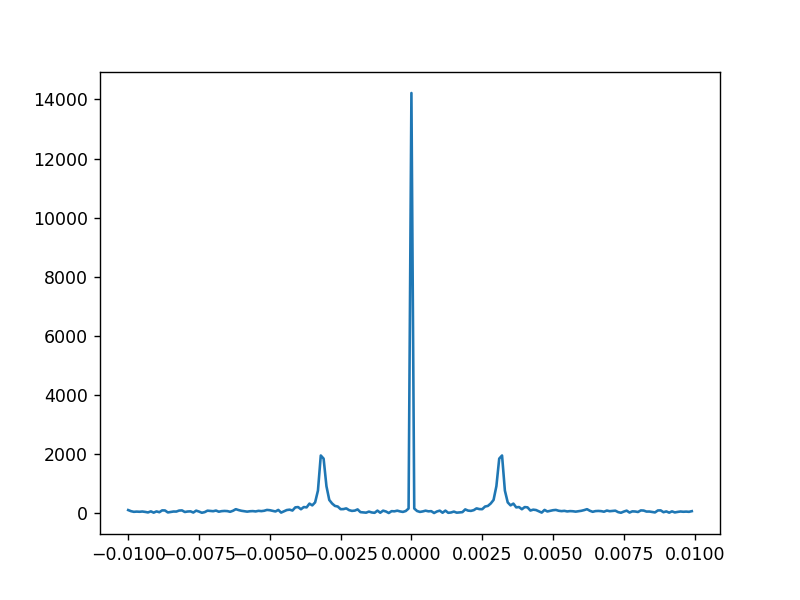

In [132]:
x, y = value[0][0],np.abs(value[0][1])
sample = (np.max(x) - np.min(x))/(len(x) - 1)
#         Ag, Cg= np.max(y)-np.min(y), np.mean(y) 
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
plt.figure()
plt.plot(yt,np.abs(amp))

# Crosstalk矩阵

In [7]:
z_crosstalk = np.ones((10,10))

<IPython.core.display.Javascript object>


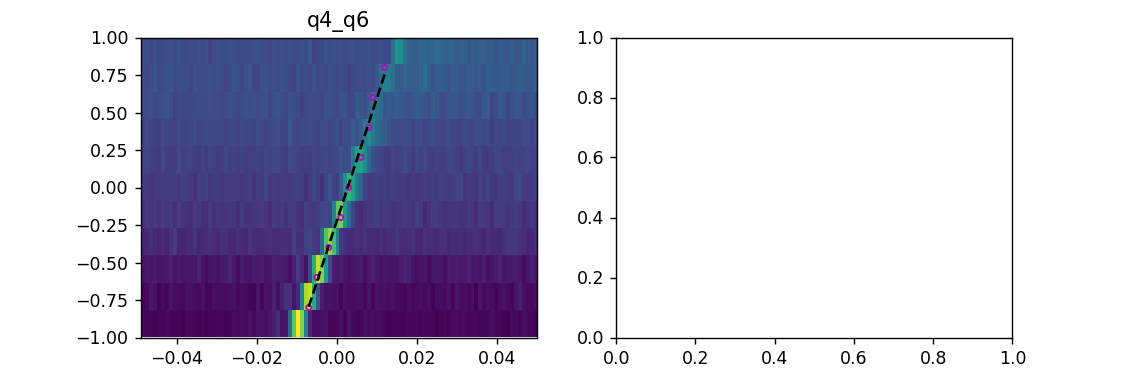

In [98]:
value,num,tags = write(height=3,title='crosstalkSpec',which=0,peak=1120)

In [ ]:
'q6-q3','q4_q7','q4-q6','q4-q5'

In [99]:
target = 1
v, f, s = value[target-1][0], value[target-1][1], value[target-1][2]
peak = (np.max(np.abs(s))+np.min(np.abs(s))) / 3
v, f, res = op.Crosstalk_Fit(peak=peak).fitCrosstalk(v,f,s,classify=False)
z = res[0]*f + res[1]
row, col = eval(tags[0][1])-1, eval(tags[0][-1])-1
z_crosstalk[col,row] = -1/res[0]
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[target-1].scatter(f[1:-1],v[1:-1],marker='.',c='',edgecolors='m')
ax[target-1].plot(f[1:-1],z[1:-1],'k--')
plt.show()

In [100]:
qname = ['q2','q3','q4','q5','q6','q7']
pd.DataFrame(z_crosstalk[1:7,1:7],columns=qname,index=qname)

,q2,q3,q4,q5,q6,q7
q2,1.000000,0.022250,0.024654,0.017860,-0.018396,-0.017770
q3,-0.008551,1.000000,0.025868,0.018411,-0.016266,-0.020069
q4,-0.002656,-0.015436,1.000000,0.016806,-0.016350,-0.015877
q5,-0.008367,-0.007255,-0.019407,1.000000,-0.022243,-0.015210
q6,-0.013860,-0.010950,-0.012242,-0.020901,1.000000,-0.023627
q7,-0.010640,-0.008685,-0.027078,-0.011156,0.013846,1.000000


# 拟合二维谱

<IPython.core.display.Javascript object>


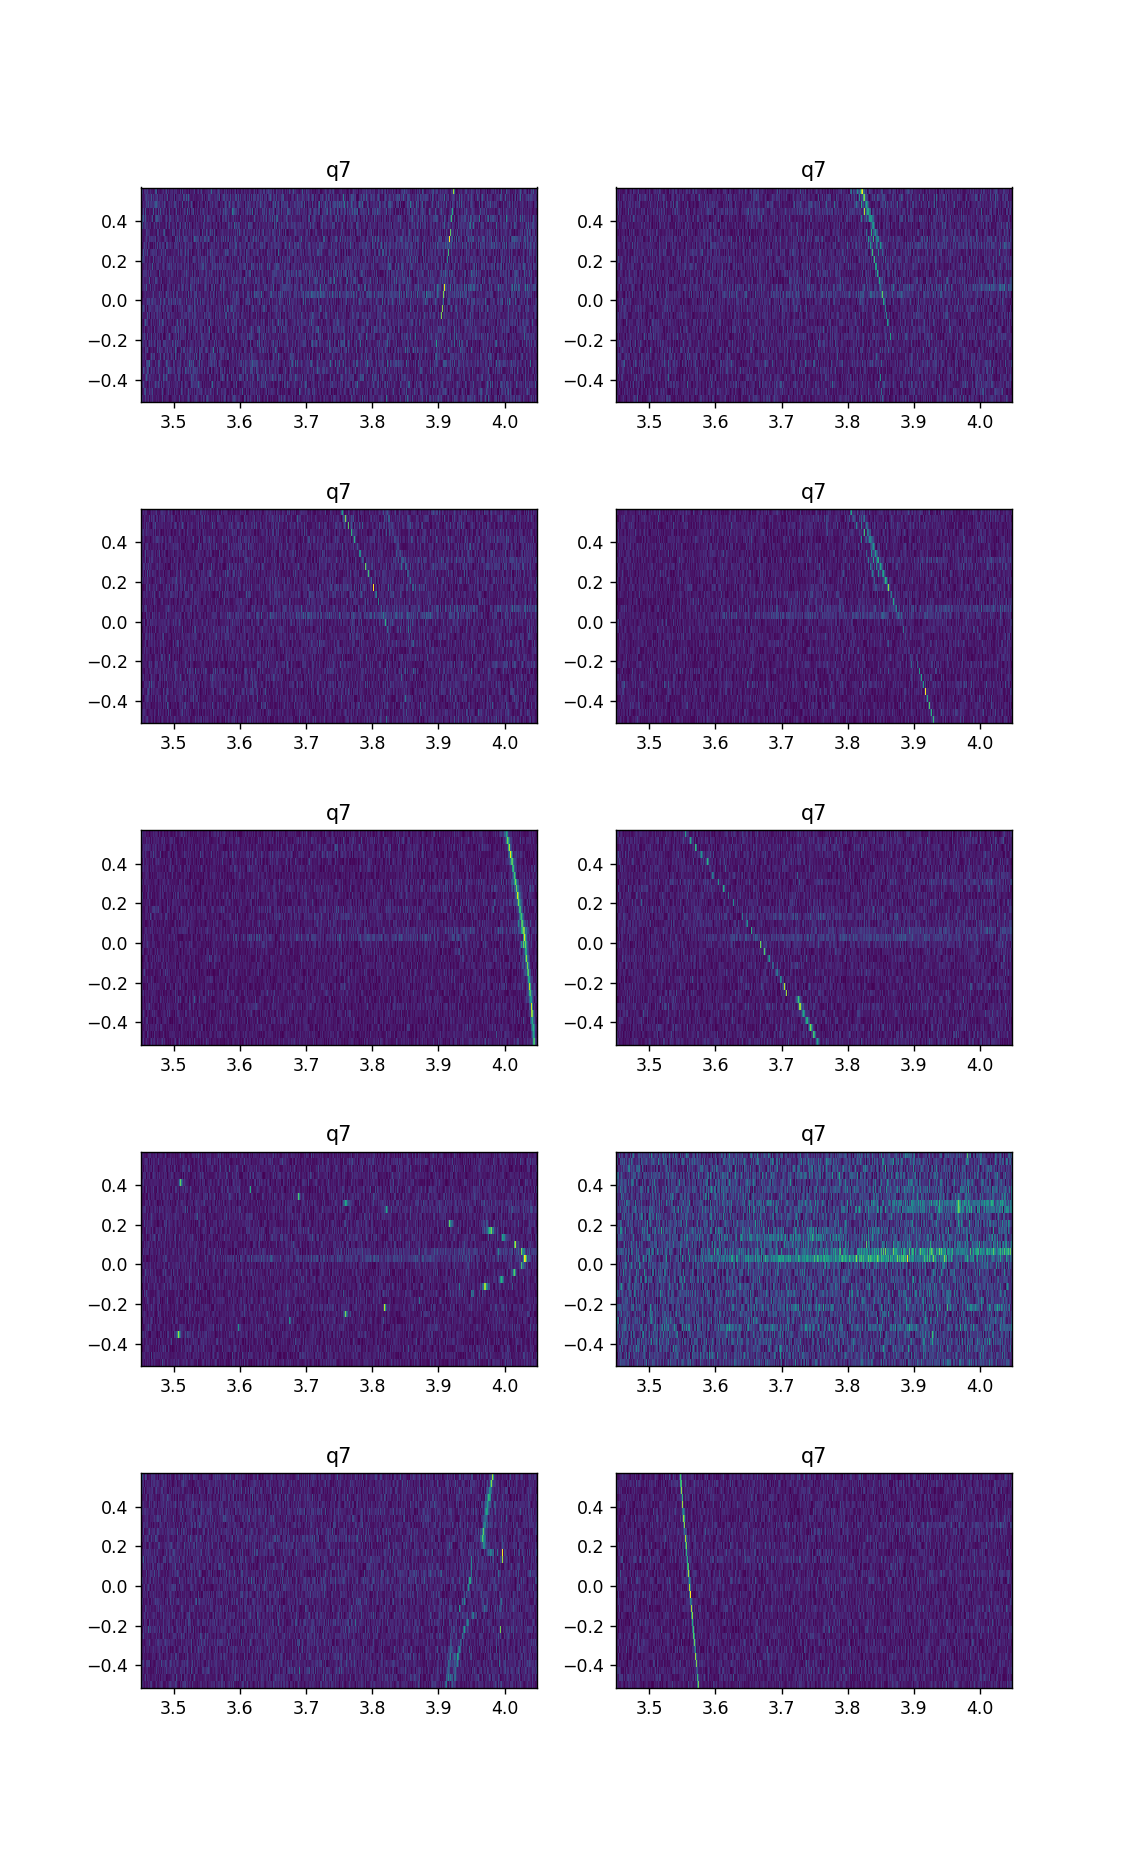

In [303]:
value,num,tags = write(height=3,title='spec2d',which=3,peak=1000)

<IPython.core.display.Javascript object>


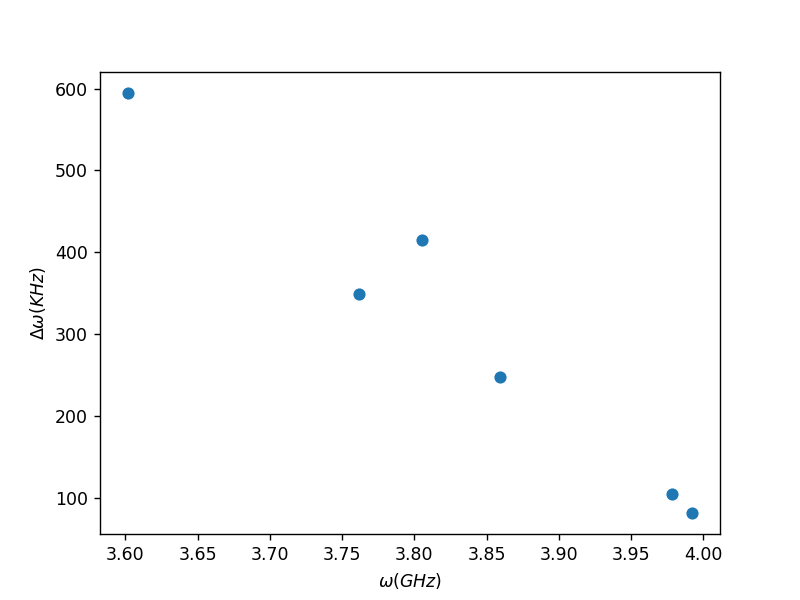

In [300]:
f = np.array([3.805,3.978,3.602,3.762,3.992,3.859])
df = np.array([0.41499,0.10439,0.59453,0.34952,0.08163,0.24785])*1e3
f_center = np.array([3.37939,3.29674,2.20569,2.98343,3.16597,2.8314])*1e3
plt.figure()
plt.plot(f,df,'o')
plt.ylabel('$\Delta \omega(KHz)$')
plt.xlabel('$\omega (GHz)$')
plt.show()

In [173]:
save('spec2d',tags,value=value,tags=tags)

WindowsPath("D:/QuLabData/2020/0330/spec2d/['old_crossover_q9']_20200330100019.npz")

In [215]:
target = 6
v, f, s = value[target-1][0], value[target-1][1]/1e9, value[target-1][2]
peak = (np.max(np.abs(s))+np.min(np.abs(s))) / 2
f,v,A, C, W, phi = op.Spec2d_Fit(peak=peak).fitSpec2d(v,f,s,classify=False)
v1 = np.linspace(min(v),max(v),1001)
z = A*np.cos(2*np.pi*W*v1+phi)+C
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[target-1].scatter(f[1:-1],v[1:-1],marker='.',c='',edgecolors='m')
ax[target-1].plot(z[1:-1],v1[1:-1],'y--')
plt.show()

0.5209999999999426 3.796391304347788 1.2178784557301183 7.617088824073541


In [216]:
x = sy.Symbol('x',real=True)
y = A*sy.cos(2*sy.pi*W*x+phi)+C

In [217]:
q6 = q6._replace(specfunc=y)

In [87]:
q4.specfunc.evalf(subs={x:0.2})

3.99929967504870

In [82]:
q4

qubit(q_name='q4', inst={'dc': 'dc11', 'z_awg': 'awg131', 'z_ch': 4, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.753, 0.176], specfunc=-199.359302124614*cos(0.0594068374593189*pi*x + 3.10601583645447) - 195.359697320355, bias=-0.2, zpulse=None, f_lo=array([6.54368e+09]), delta=array([50000000.]), f_ex=array([3.77395348e+09]), delta_ex=array([0]), power_ex=30, pi_len=19.0, T1=26511.572081147293)

# 拟合调制曲线找周期

In [8]:
n = 10
Tlist = {}
matrix_cross = np.zeros((n,n)) #收集crosstalk矩阵元
matrix_phi = np.zeros((n,n))

<IPython.core.display.Javascript object>


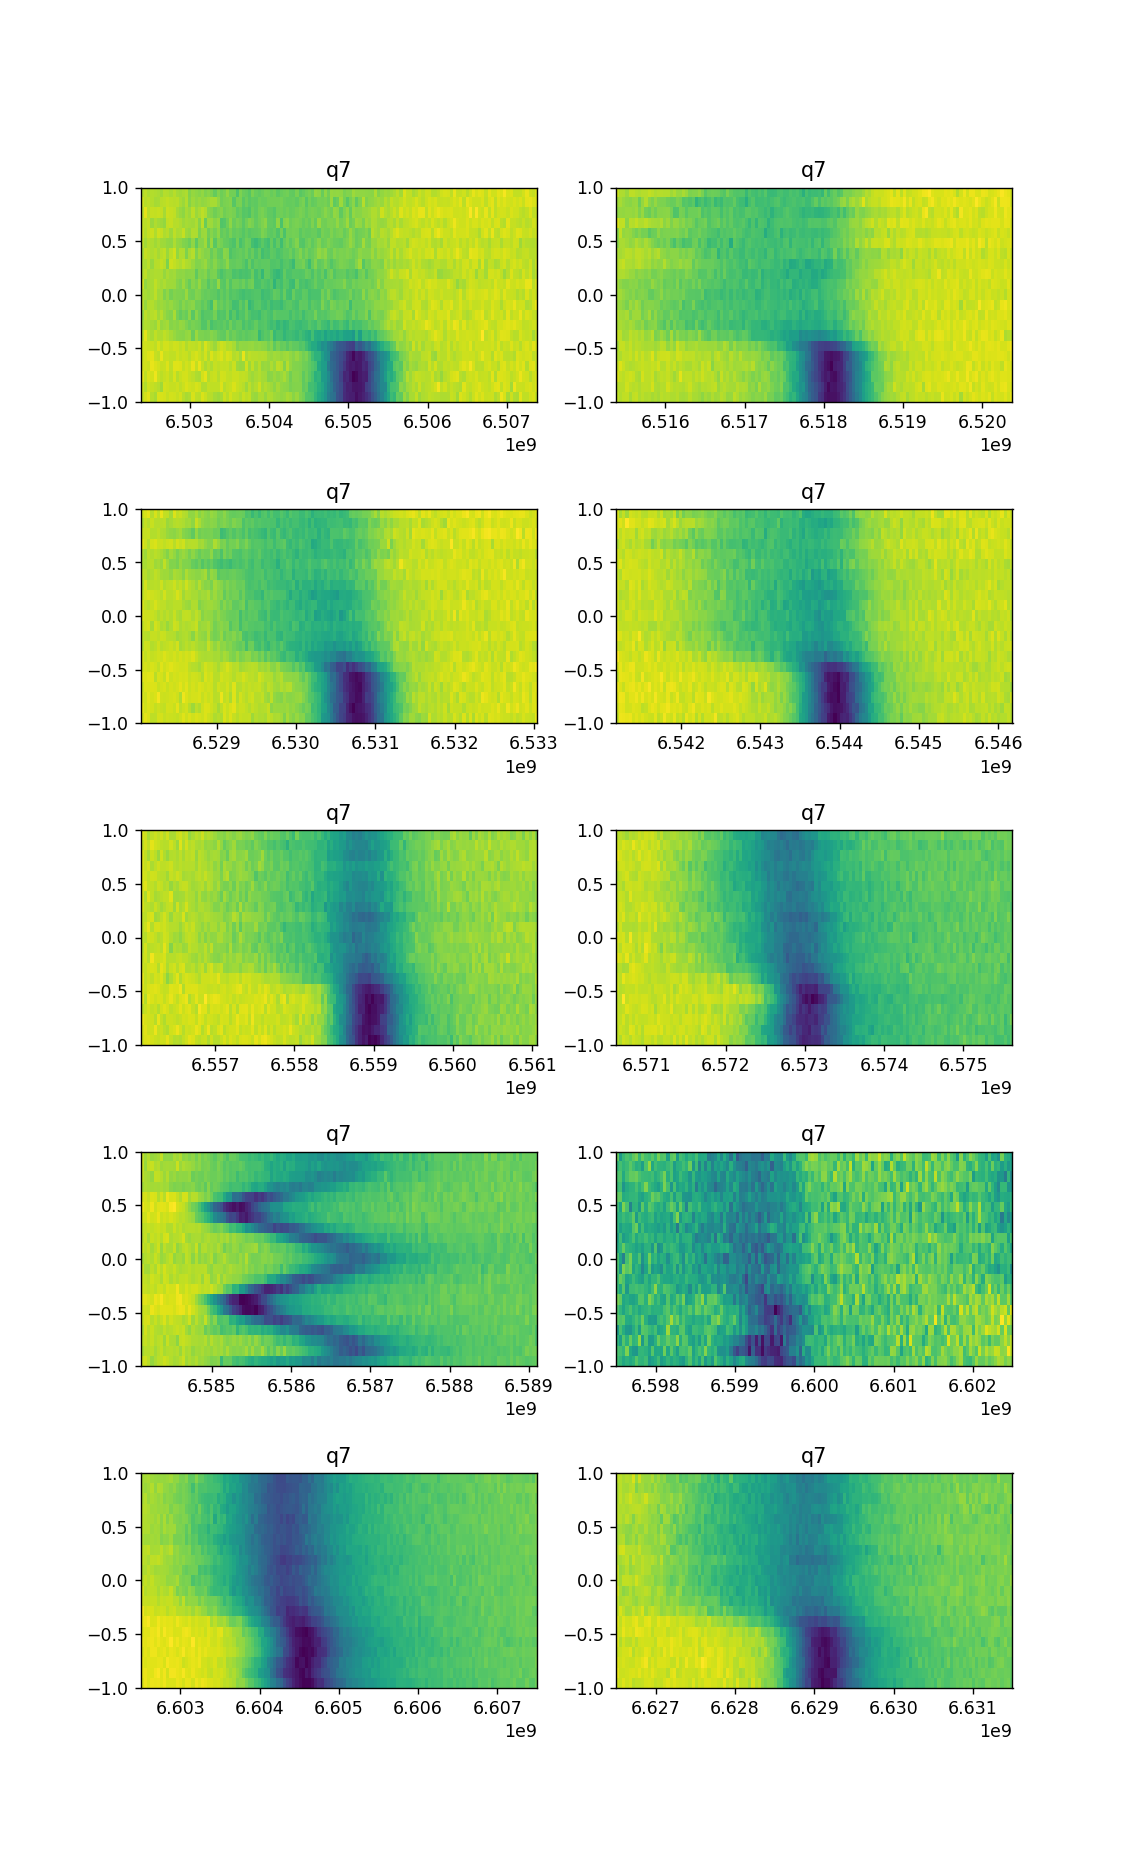

['q7']

In [610]:
value,num,tags = write(height=3,title='S21vsFlux_awgoffset',which=1,peak=1000) #S21vsFlux_awgoffset
tags

In [160]:
q10

qubit(q_name='q10', inst={'dc': 'dc10', 'z_awg': 'awg131', 'z_ch': 8, 'ex_awg': 'awg132', 'ex_ch': [5, 6], 'ex_lo': 'psg_ex2', 'com': 'com6'}, T_bias=[2.032, 0.368], specfunc=-93.2181910291993*cos(0.0733463105673384*pi*x + 3.124208850395) - 89.3095042728714, bias=-0.298, zpulse=None, f_lo=[6629000000.0], delta=array([50000000.]), f_ex=array([3.684e+09]), delta_ex=array([0]), power_ex=50, pi_len=None, T1=None)

In [30]:
n_target = 1
mat = fit_cos(tag='q_%d'%n_target)
matrix_cross[:,n_target-1] = np.array(mat)[:,0]
matrix_phi[:,n_target-1] = np.array(mat)[:,1]
Tlist

0.0015599999999995617 6.50441619047619 0.47619047619047616 2.0406939339584707
0.00039999999999995595 6.518013333333333 0.23809523809523808 2.6095230475281785
0.000600000000000378 6.530670476190476 0.23809523809523808 2.5908671471132276
0.0005999999999994898 6.543894285714285 0.23809523809523808 2.6786355511772317
0.000280000000000058 6.558882857142857 0.23809523809523808 2.7586064901673106
0.0007599999999996498 6.572989523809525 0.23809523809523808 2.616054749597904
0.00016000000000016001 6.586873333333334 0.23809523809523808 2.6698133884013626
0.00048000000000048004 6.599467619047617 0.7142857142857142 2.586984801483541
0.00032000000000032003 6.604528571428572 0.23809523809523808 1.6237494682460536
0.000280000000000058 6.629115238095238 0.23809523809523808 2.5510566640225343


{'q10': [2.032, 0.368],
 'q9': [1.723, 0.036],
 'q8': [1.665, 0.2],
 'q7': [1.801, 0.028],
 'q6': [1.785, -0.308],
 'q5': [1.803, 0.068],
 'q4': [1.753, 0.176],
 'q3': [1.759, 0.224],
 'q2': [1.896, 0.22],
 'q1': [2.038, 0.104]}

In [11]:
def fit_cos(tag):
    mat = []
    At = 0
    for i in range(len(value)):
        volt, freq, s = value[i]
        #volt, s = volt[3:-3], s[3:-3,:]
        x, y = op.RowToRipe().manipulation(volt,freq,s)
        A, C, W, phi = op.Cos_Fit().fitCos(x,y)
        T = 1 / W
        fig = plt.gcf() 
        axes = plt.getp(fig,'axes')
        axes[i].plot(y,x,'ro')
        x1 = np.linspace(min(volt),max(volt),1001)
        y1 = A*np.cos(2*np.pi/T*x1+phi)
        axes[i].plot(y1+C,x1,'b-')
        #if i != int(tag[2:]) - 1:
        t = symbols("t")
        z = A*sy.cos(2*np.pi/T*t+phi)+C
        z_diff = diff(z,t)
        if z_diff.evalf(subs = {t:0}) < 0:
            T *= -1
            if phi<0:
                phi *= -1
        phi = phi % (2*np.pi)
        mat.append((1/T,phi))
        if i == int(tag[2:]) - 1:
            bias0 = op.RowToRipe().firstMax(x1,y1,num=0)
            Tlist[tags[0]] = [round(np.abs(T),3),bias0]
        axes[i].set_title(r'$ q%d,T = %g,phi=%g $' %(i+1,T,phi))
    return mat
        

In [32]:
bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
for i, j in enumerate(bit):
    globals()['q%d'%(i+1)] = j._replace(T_bias=Tlist['q%d'%(i+1)])

# 拟合T1

<IPython.core.display.Javascript object>


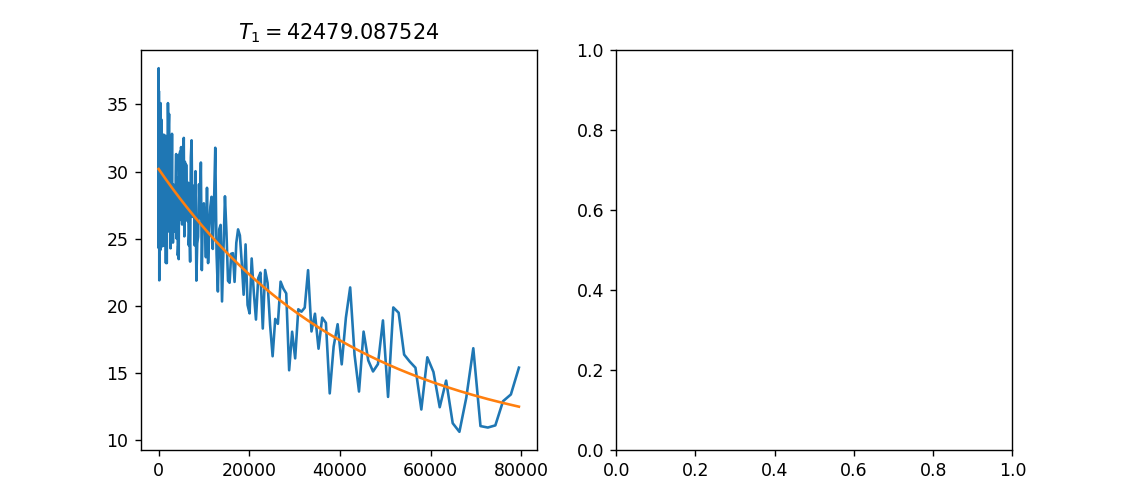

In [10]:
value,num,tags = write(height=4,title='T1',which=0)

In [11]:
x, y = value[0][0], value[0][1]
A, B, T1 = op.Exp_Fit().fitExp(x,np.abs(y))
z = A * np.exp(-x/T1) + B
fig = plt.gcf()
ax = plt.getp(fig,'axes')
ax[0].plot(x,z)
ax[0].set_title('$T_{1}=%f$'%T1)
plt.show()

# 拟合Rabi

<IPython.core.display.Javascript object>


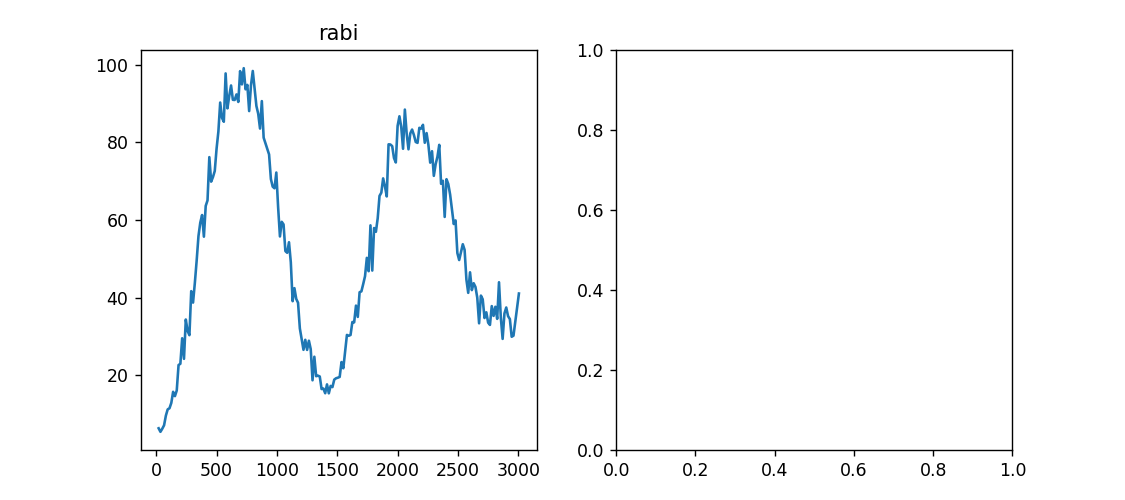

In [466]:
value,num,tags = write(height=4,title='rabi',which=1)

In [21]:
op.RowToRipe().firstMax(value[0][0],np.abs(value[0][1]),num=270)

163.0

In [22]:
fig = plt.gcf()
ax = plt.getp(fig,'axes')
for i in range(num):
    x, y  = value[i][0], value[i][1]
    A,B,T1,w,phi = op.Rabi_Fit(envelopemethod='hilbert').fitRabi(np.abs(x),np.abs(y))
    z = A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B
    ax[i].plot(x,z)
    ax[i].set_title('$T_{1}=%f,period=%f$'%(T1,1/w/2))
plt.show()

(14.080866727459266, 110.38764015435805, 20000, 0.012, 1.5707963267948966)


d:\qulab\qulab\optimize.py:276: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-x/T1)*np.cos(2*np.pi*w*x+phi) + B - y


In [12]:
np.shape(x)

(500,)

# 拟合Ramsey及SpinEcho

<IPython.core.display.Javascript object>


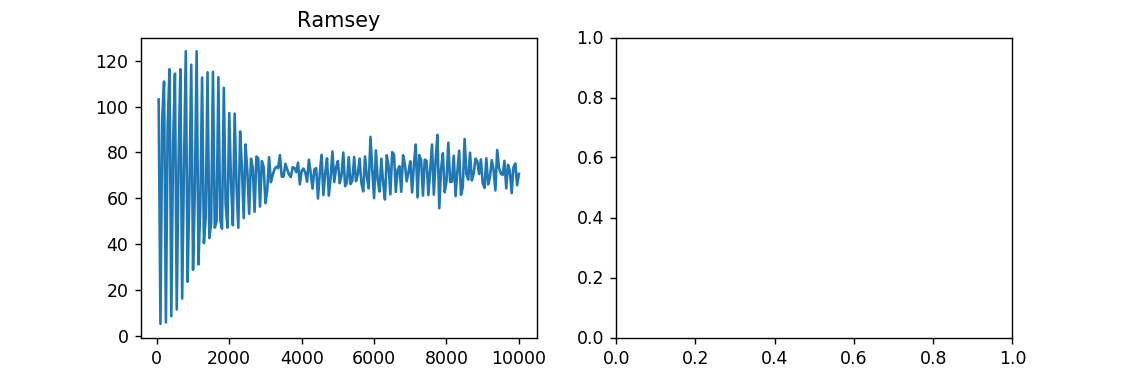

In [304]:
value,num,tags = write(height=3,title='Ramsey',which=0)

In [126]:
fig = plt.gcf()
ax = plt.getp(fig,'axes')
for i in range(num):
    x, y  = value[i][0], value[i][1]
    sample = (np.max(x) - np.min(x))/(len(x) - 1)
    yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
    amp = np.fft.fftshift(np.fft.fft(y))
    A,B,T1,T2,w,phi = op.T2_Fit(funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
    z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
    z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
    ax[i].plot(x,z)
    ax[i].plot(x,z_env)
    ax[i].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
    ax[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

(66.55199492976796, 14.487426344018695, 35000, 6563.792998766753, 0.0032, 0)
